# **Project: Time Series - Forecasting Stock Prices**
# Marks: 30

Welcome to the project on Time Series. We will use the Amazon Stock Prices dataset for this project.
 
----------------
## **Context:** 
----------------

**Stocks are one of the most popular financial instruments invented for building wealth** and are the **centerpiece of any investment portfolio.** Recent advances in trading technology have opened up stock markets in such a way that nowadays, **nearly anybody can own stock.** 

In the last few decades, there's been an **explosive increase in the average person's interest for the stock market.** This makes stock value prediction an interesting and popular problem to explore.


------------------
## **Objective:**
------------------

Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America as well as internationally. This dataset consists of monthly average stock closing prices of Amazon over a period of 12 years from 2006 to 2017. We have to **build a time series model** using the AR, MA, ARMA and ARIMA models in order to **forecast the stock closing price of Amazon.**

--------------------------
## **Data Dictionary:**
--------------------------
- **date:** Date when the price was collected
- **close:** Closing price of the stock

### Importing libraries

In [1]:
# Install this to upgrade the statsmodels package. It will be required to use AR, MA, & ARMA models

!pip install statsmodels==0.12.1

In [2]:
#If the above command doesn't work, please run the below command in the anaconda prompt, otherwise ignore
#conda install statsmodels

In [3]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

#Importing libraries for visualization
import matplotlib.pylab as plt
import seaborn as sns

#Importing library for date manipulation
from datetime import datetime

#To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

#Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

#To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the dataset

In [4]:
#If you are having an issue while loading the excel file in pandas, please run the below command in anaconda prompt, otherwise ignore.
#conda install -c anaconda xlrd

In [5]:
df = pd.read_excel('amazon_stocks_prices.xlsx')
df.head()

,date,close
0,2006-01-01,45.22
1,2006-02-01,38.82
2,2006-03-01,36.38
3,2006-04-01,36.32
4,2006-05-01,34.13


### Checking info 

### **Question 1: Check the info of the dataset and write your observations. (2 Marks)**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    144 non-null    datetime64[ns]
 1   close   144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


**Observations:**

- There are two columns with attributes date and close
- 144 observations in each column
- data type for data 'column' is datetime64, so its shows the day and time with 64 bit integer
- data type for 'close' column is float64, so it is a decimal 64 bit integer
- all values are non-null, so no missing values

In [7]:
# Setting date as the index
df = df.set_index(['date'])
df.head()

,close
date,
2006-01-01,45.22
2006-02-01,38.82
2006-03-01,36.38
2006-04-01,36.32
2006-05-01,34.13


Now, let's **visualize the time series** to get an idea about the trend and/or seasonality within the data.

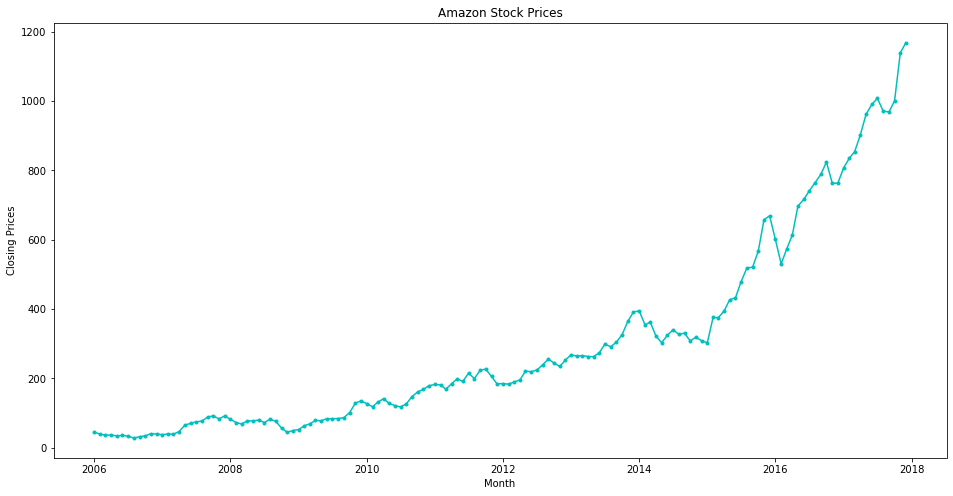

In [8]:
# Visualizing the time series
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Closing Prices")
plt.title('Amazon Stock Prices')
plt.plot(df.index, df.close, color = 'c', marker='.')

**Observations:**
- We can see that the series has an **upward trend with some seasonality.** This implies that the **average stock price of Amazon has been increasing almost every year.**
- Before building different models, it is important to **check whether the series is stationary or not.**

Let us first split the dataset into train and test data

### Splitting the dataset

In [9]:
# Splitting the data into train and test
df_train = df.loc['2006-01-01':'2015-12-01']
df_test = df.loc['2016-01-01' : '2017-12-01']
print(df_train)
print(df_test)

             close
date              
2006-01-01   45.22
2006-02-01   38.82
2006-03-01   36.38
2006-04-01   36.32
2006-05-01   34.13
...            ...
2015-08-01  518.46
2015-09-01  520.96
2015-10-01  566.74
2015-11-01  657.70
2015-12-01  669.26

[120 rows x 1 columns]
              close
date               
2016-01-01   601.06
2016-02-01   530.62
2016-03-01   572.37
2016-04-01   613.59
2016-05-01   697.47
2016-06-01   716.39
2016-07-01   741.47
2016-08-01   764.84
2016-09-01   788.97
2016-10-01   824.44
2016-11-01   763.34
2016-12-01   763.33
2017-01-01   807.51
2017-02-01   835.75
2017-03-01   854.24
2017-04-01   903.39
2017-05-01   961.72
2017-06-01   990.44
2017-07-01  1008.48
2017-08-01   971.44
2017-09-01   968.99
2017-10-01  1000.72
2017-11-01  1139.81
2017-12-01  1168.84


Now let us check the **rolling mean and standard deviation** of the series to **visualize if the series has any trend or seasonality.**

### Testing the stationarity of the series

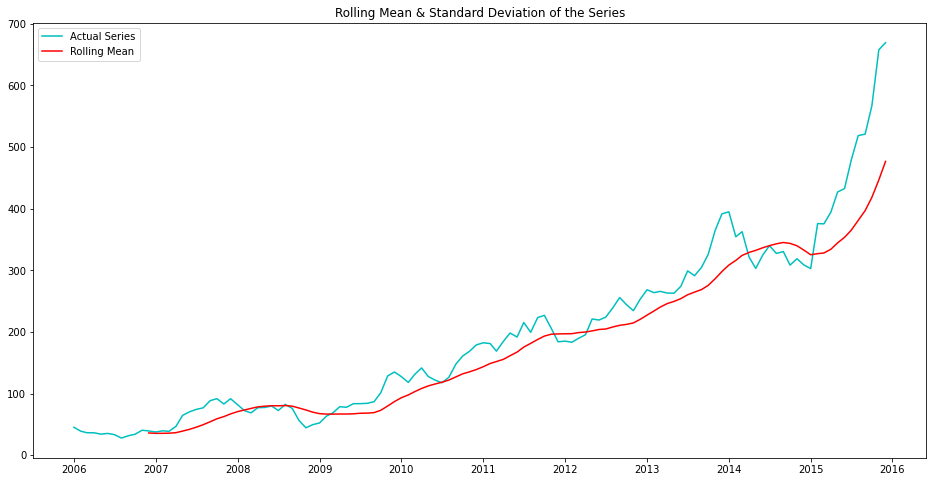

In [10]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df_train.rolling(window=12).mean()
rolstd=df_train.rolling(window=12).std()

#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df_train, color='c', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 
#rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

**Observations:**
- We can see there is an upward trend in the series.
- We can confirm that **the series is not stationary.**

We can also use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [11]:
#Define a function to use adfuller test
def adfuller(df_train):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df_train['close'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(df_train)

Dickey-Fuller Test: 
Test Statistic            3.464016
p-value                   1.000000
Lags Used                 0.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:**
1. From the above test, we can see that the **p-value = 1 i.e. > 0.05** (For 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Hence, **we can confirm that the series is non-stationary.**

### Making the series stationary

We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation**
2. **By differencing the series (lagged series)**

Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

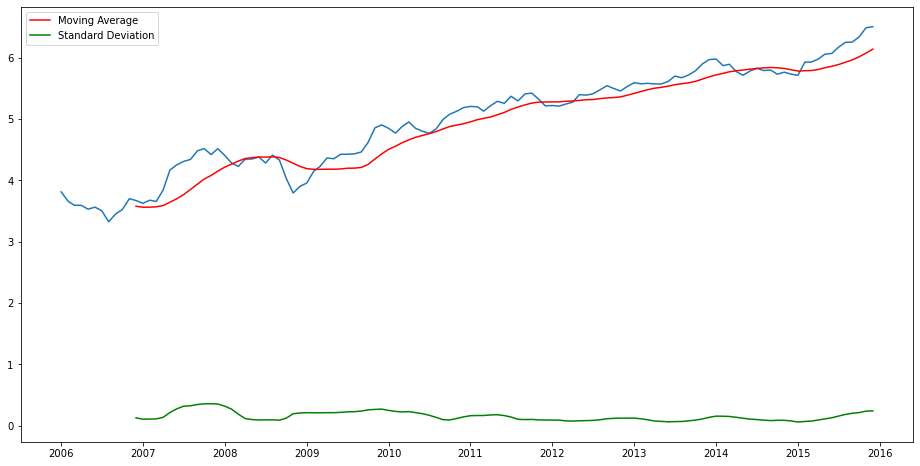

In [12]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df_train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

**Observations:**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant which implies that **now the series has constant variance.**

**Let's shift the series by order 1 (or by 1 month) & apply differencing (using lagged series)** and then check the rolling mean and standard deviation.

### **Question 2: Visualize the rolling mean and rolling standard deviation of the shifted series (df_shift) and check the stationarity by calling the adfuller() function. Also, write your observations on the same. (3 Marks)**

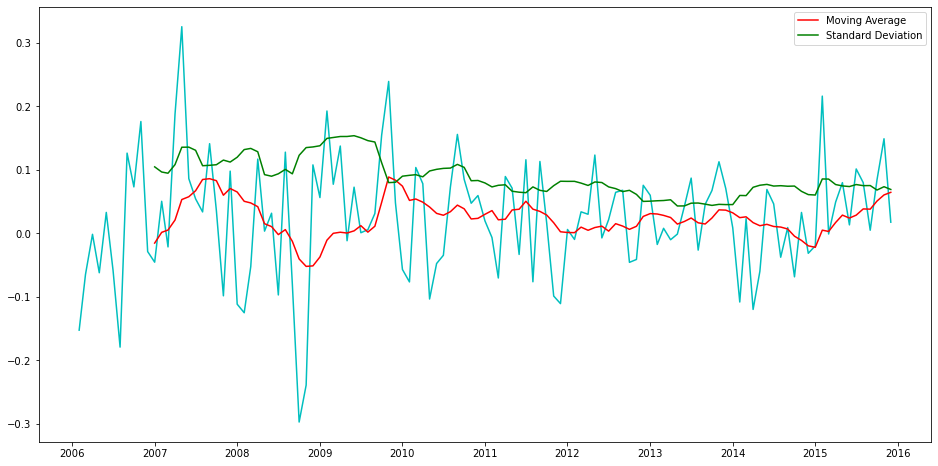

In [13]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()


#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()


**Observations:** 
- moving average and stand deviation have lost trend
- mean and standard deviation now seem to look constant overtime.
- this may imply that series is stationary but we still still need to test for stationarity below. 


Let us use the adfuller test to check the stationarity.

In [14]:
adfuller(df_shift) # call the adfuller function for df_shift series

Dickey-Fuller Test: 
Test Statistic         -8.640344e+00
p-value                 5.447548e-14
Lags Used               0.000000e+00
No. of Observations     1.180000e+02
Critical Value (1%)    -3.487022e+00
Critical Value (5%)    -2.886363e+00
Critical Value (10%)   -2.580009e+00
dtype: float64


**Observations:**
- from the Dicky-Fuller test we can see the p-value is way less than 0.05 (5.45 x 10^-14). So we can reject the null hypothesis
- series is stationary

Let's decompose the time series to check its different components.

### Decomposing the time series components into Trend, Seasonality and Residual

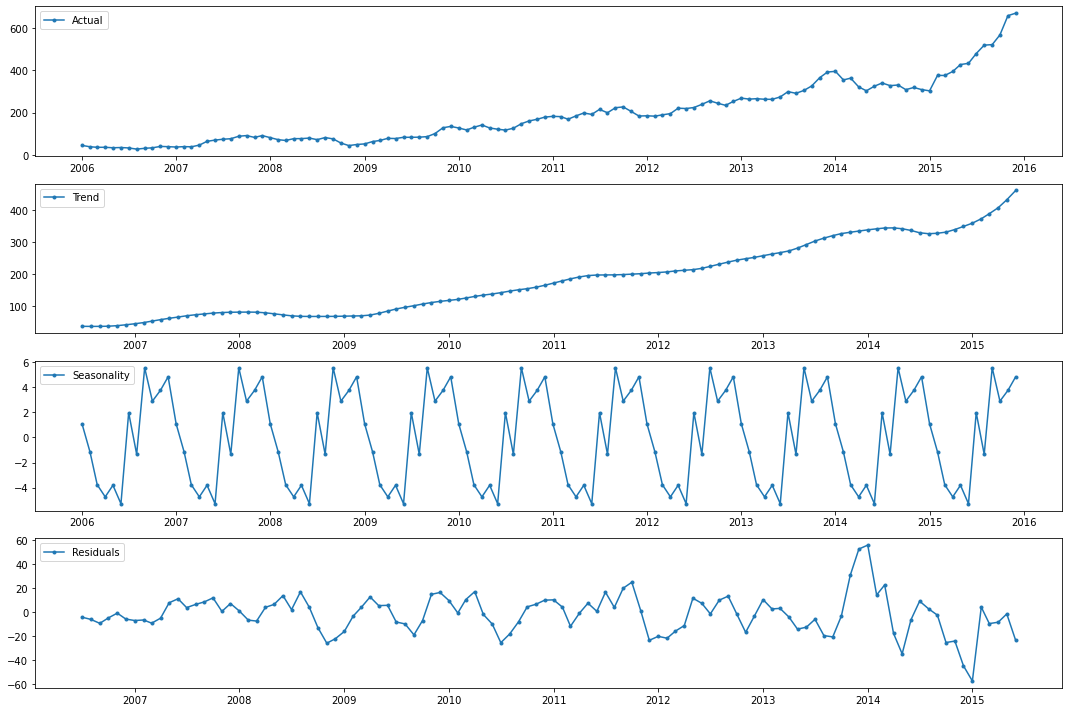

In [15]:
#Importing the seasonal_decompose function to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_train)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(df_train, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

**Observations:**
- We can see that there are significant **trend, seasonality and residuals components** in the series
- The plot for seasonality shows that **Amazon's stock prices spike in July, September, and December.**

**Now let's move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q i.e. order of AR and MA models to be used.**

### Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models

<Figure size 1152x576 with 0 Axes>

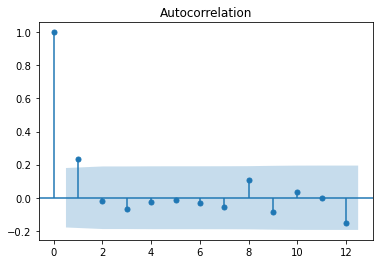

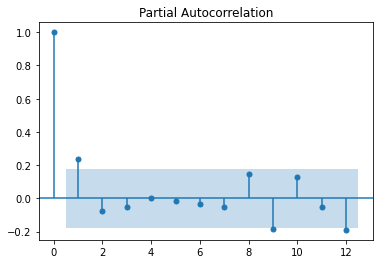

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 12) 
plt.show() 
plot_pacf(df_shift, lags = 12) 
plt.show()

**Observations:**
- From the above PACF plot we can see that **the highest lag** at which the plot extends beyond the statistically significant boundary is **lag 1.** 
- This indicates that an **AR Model of lag 1 (p=1)** should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that **q=1.**

### AR Model

### **Question 3: Fit and predict the shifted series with the AR Model and calculate the RMSE. Also, visualize the time series and write your observations. (5 Marks)**

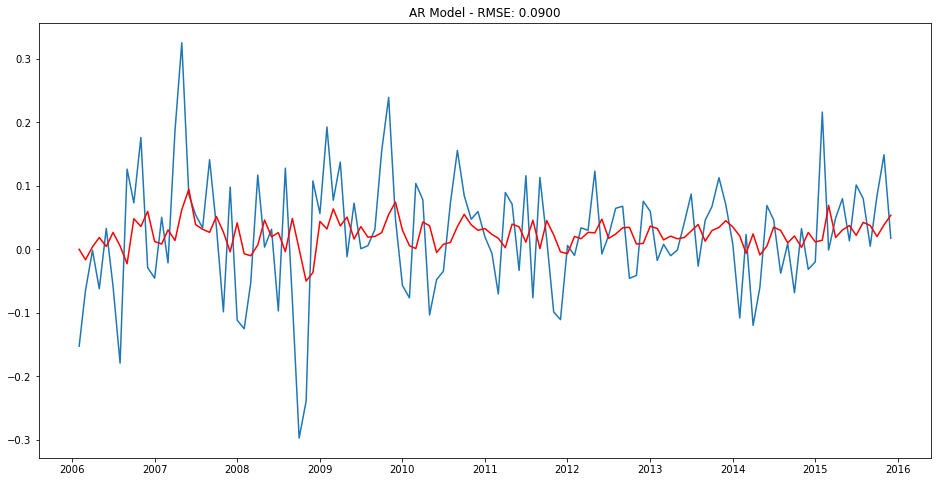

In [17]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=1) #Use number of lags as 1 and apply AutoReg function on df_shift series
results_AR = model_AR.fit() #fit the model
plt.plot(df_shift)
predict = results_AR.predict(start=0,end=len(df_shift)-1) #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict,df_shift['close'], squared=False))  #Calculating rmse
plt.show()

**Observations:**
- by using the AR model we get the root mean square error of 0.0900
- RMSE is the square root of the variance of the residuals, it shows how close the data points are to models predicted values. You can say RMSE is the standard deviation of the unexplained variance. A low RMSE indicated a better fit as this AR model above does. 


**Let's check the AIC value** of the model

In [18]:
results_AR.aic

-4.781419615400342

Now, let's build MA, ARMA, and ARIMA models as well, and see if we can get a better model 

### MA Model

**We will be using an ARIMA model with p=0 and d=0 so that it will work as an MA model**

### **Question 4: Fit and predict the shifted series with the MA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

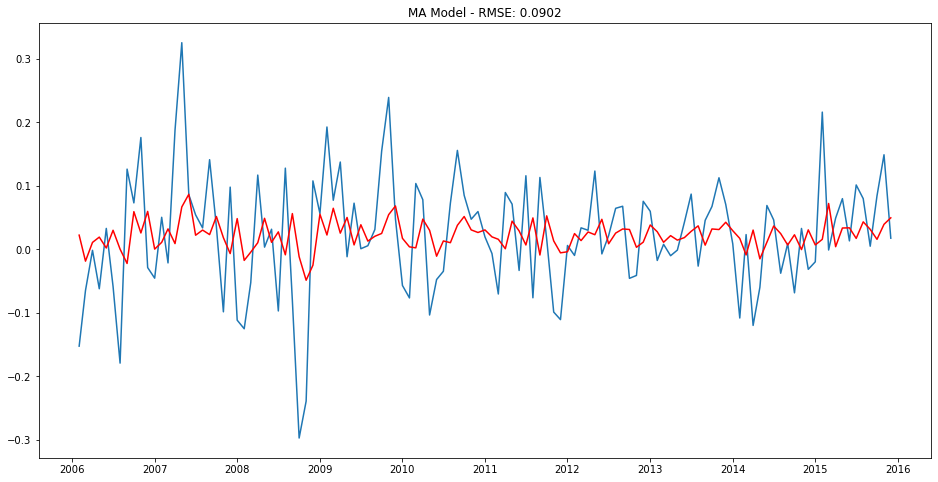

In [19]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order=(0, 0, 1)) #Using p=0, d=0, q=1 and apply arima function on df_shift series
results_MA = model_MA.fit()
plt.plot(df_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues,df_shift['close'], squared=False))
plt.show()



**Observations:**
- the MA model is giving a slight bit higher RMSE value (0.0902 vs 0.0900).
- both MA and AR model look similar but if you look very close to the plotted value (red line) there is slight variation

Let's check the AIC value of the model

In [20]:
results_MA.aic

-229.09493930954125

- **The MA model is giving a much lower AIC** when compared to the AR model, implying that **the MA model fits the training data better.** 

### ARMA Model

We will be using an **ARIMA model with p=1 and q=1** (as observed from the ACF and PACF plots) **and d=0 so that it will work as an ARMA model.**

### **Question 5: Fit and predict the shifted series with the ARMA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

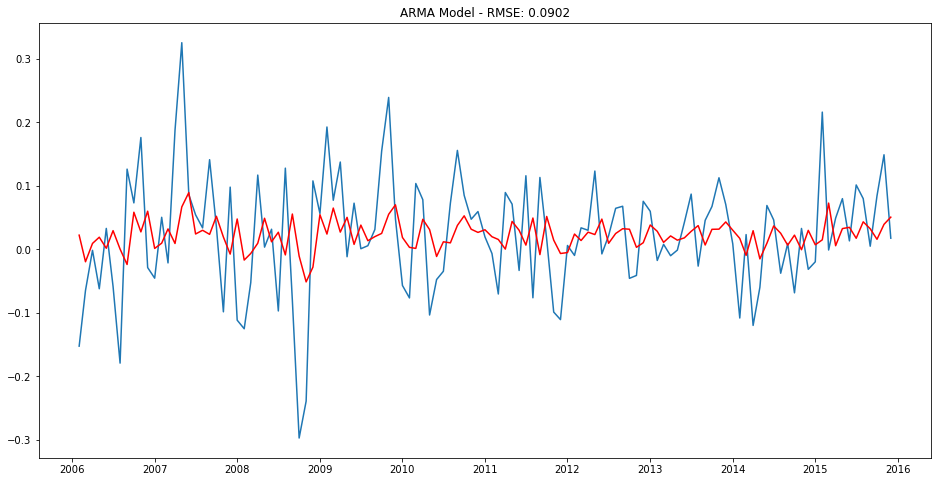

In [21]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_shift, order=(1, 0, 1)) #Using p=1, d=0, q=1 and apply ARIMA function on df_shift series
results_ARMA = model_ARMA.fit() #fit the model
plt.plot(df_shift)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**
- looks eactly like the moving-average model

**Let's check the AIC value** of the model

In [22]:
results_ARMA.aic

-227.11129236959528

- **The AIC value of the ARMA model is more or less similar** to MA model 

**Let us try using the ARIMA Model.**

### ARIMA Model

We will be using an **ARIMA Model with p=1, d=1, & q=1**.

### **Question 6: Fit and predict the shifted series with the ARIMA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

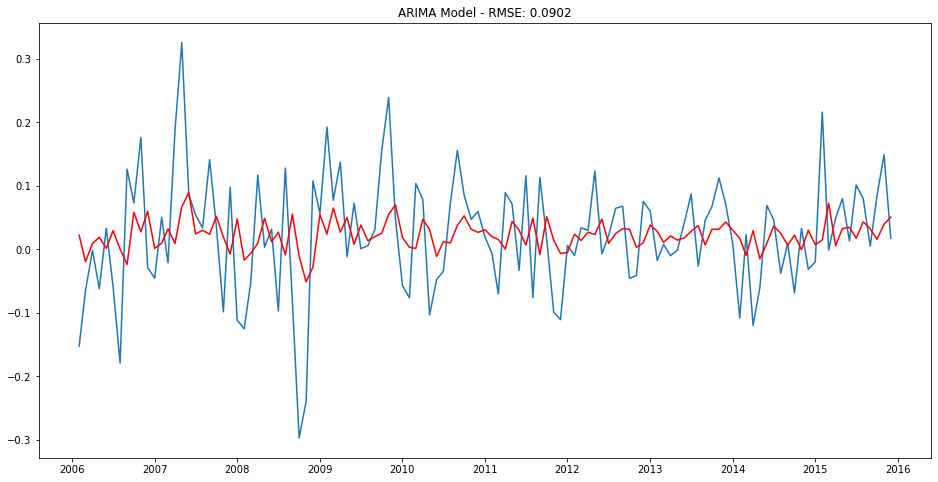

In [23]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_log, order=(1,1,1)) #Using p=1, d=1, q=1 and apply ARIMA function on df_log series
results_ARIMA = model_ARIMA.fit() #fit the model
plt.plot(df_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**
- Looks similar to other models and the same RMSE as the MA and ARMA model.
- this model has no non-seasonal differences, this is why it becomes the same as a ARMA model
- im guessing d=0 as the model is already stationary. d is differencing between current and past value.

**Let's check the AIC value** of the model

In [24]:
results_ARIMA.aic

-227.11129236959528

- **The AIC value of the ARIMA model is the same** as the ARMA model. 

We can see that **all the models return almost the same RMSE.** There is not much difference in AIC value as well across all the models except for the AR model.

**We can choose to predict the values using ARIMA as it takes into account more factors than AR, MA, ARMA models.**

In [25]:
# Printing the fitted values
predictions=pd.Series(results_ARIMA.fittedvalues)
predictions

date
2006-02-01    0.022235
2006-03-01   -0.019667
2006-04-01    0.009184
2006-05-01    0.018985
2006-06-01    0.001615
                ...   
2015-08-01    0.043234
2015-09-01    0.032286
2015-10-01    0.015696
2015-11-01    0.039276
2015-12-01    0.050567
Length: 119, dtype: float64

### Inverse Transformation

Now we have fitted values using the ARIMA model, **we will use the inverse transformation to get back the original values.**

### **Question 7: Apply an inverse transformation on the predictions of the ARIMA Model. (5 Marks)**

In [26]:
#First step - doing cumulative sum
predictions_cumsum = predictions.cumsum() # use .cumsum fuction on the predictions
predictions_cumsum

date
2006-02-01    0.022235
2006-03-01    0.002568
2006-04-01    0.011753
2006-05-01    0.030738
2006-06-01    0.032353
                ...   
2015-08-01    2.526098
2015-09-01    2.558385
2015-10-01    2.574080
2015-11-01    2.613357
2015-12-01    2.663924
Length: 119, dtype: float64

In [27]:
#Second step - Adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['close'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log

date
2006-01-01    3.811539
2006-02-01    3.833774
2006-03-01    3.814108
2006-04-01    3.823292
2006-05-01    3.842277
                ...   
2015-08-01    6.337638
2015-09-01    6.369924
2015-10-01    6.385620
2015-11-01    6.424896
2015-12-01    6.475464
Length: 120, dtype: float64

In [28]:
#Third step - applying exponential transformation
predictions_ARIMA = np.exp(predictions_log) #use exponential function
predictions_ARIMA

date
2006-01-01     45.220000
2006-02-01     46.236724
2006-03-01     45.336291
2006-04-01     45.754597
2006-05-01     46.631542
                 ...    
2015-08-01    565.458958
2015-09-01    584.013466
2015-10-01    593.252355
2015-11-01    617.016851
2015-12-01    649.020026
Length: 120, dtype: float64

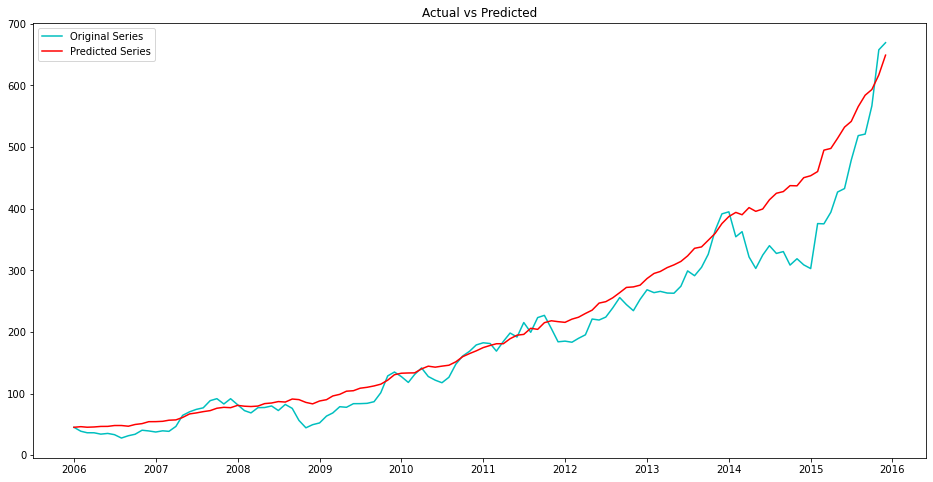

In [29]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_train, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions_ARIMA 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- We can see that **the predicted series is very similar to the original series** i.e. The model is good at predicting values on the training data except for the dip in stock prices in 2015 which may have been due to some external factors that are not included in this model. 
- Let us **forecast the closing prices for the next 24 months.**

### Forecasting the values for next 24 months and compare it with test data

**To forecast the values for the next 24 months using the ARIMA model, we need to follow the steps below:**
1. Forecast the log-transformed fitted values for the next 24 months
2. Make a list of these 24 month (2016-2017) forecasted values
3. Convert that list into a series so that we can work with pandas functions 
4. Make a dataframe where we have the dates starting from 2016-01-01 to 2017-12-01 as the index and the respective forecasted values
5. Apply the inverse transformation and get the real forecasted values

### **Question 8: Forecast the stocks prices for the next 24 months and perform the inverse transformation. (5 Marks)**

In [30]:
#Forecasting the values for next 24 months
forecasted_ARIMA = results_ARIMA.forecast(steps=24) #forecast using the results_ARIMA for next 24 months. Keep steps=24
forecasted_ARIMA[0]

array([6.52115938, 6.54310818, 6.5653318 , 6.58756626, 6.60980115,
       6.63203606, 6.65427097, 6.67650588, 6.69874079, 6.7209757 ,
       6.74321061, 6.76544552, 6.78768043, 6.80991534, 6.83215025,
       6.85438516, 6.87662007, 6.89885498, 6.92108989, 6.9433248 ,
       6.96555971, 6.98779463, 7.01002954, 7.03226445])

In [31]:
# Creating a list containing all the forecasted values
list1 = forecasted_ARIMA[0].tolist()
series1 = pd.Series(list1)
series1

0     6.521159
1     6.543108
2     6.565332
3     6.587566
4     6.609801
5     6.632036
6     6.654271
7     6.676506
8     6.698741
9     6.720976
10    6.743211
11    6.765446
12    6.787680
13    6.809915
14    6.832150
15    6.854385
16    6.876620
17    6.898855
18    6.921090
19    6.943325
20    6.965560
21    6.987795
22    7.010030
23    7.032264
dtype: float64

In [32]:
#Making a new dataframe to get the additional dates from 2016-2018
index = pd.date_range('2016-01-1','2018-1-1' , freq='1M')- pd.offsets.MonthBegin(1)
df1 = pd.DataFrame()
df1['forecasted'] = series1
df1.index = index
df1

,forecasted
2016-01-01,6.521159
2016-02-01,6.543108
2016-03-01,6.565332
2016-04-01,6.587566
2016-05-01,6.609801
2016-06-01,6.632036
2016-07-01,6.654271
2016-08-01,6.676506
2016-09-01,6.698741
2016-10-01,6.720976


In [33]:
#Applying exponential transformation to the forecasted log values
forecasted_ARIMA = np.exp(df1['forecasted']) #use exponential function on forecasted data
forecasted_ARIMA

2016-01-01     679.365574
2016-02-01     694.441677
2016-03-01     710.047448
2016-04-01     726.011794
2016-05-01     742.335393
2016-06-01     759.026023
2016-07-01     776.091924
2016-08-01     793.541535
2016-09-01     811.383482
2016-10-01     829.626586
2016-11-01     848.279867
2016-12-01     867.352547
2017-01-01     886.854057
2017-02-01     906.794038
2017-03-01     927.182348
2017-04-01     948.029068
2017-05-01     969.344504
2017-06-01     991.139196
2017-07-01    1013.423918
2017-08-01    1036.209689
2017-09-01    1059.507774
2017-10-01    1083.329692
2017-11-01    1107.687220
2017-12-01    1132.592402
Name: forecasted, dtype: float64

Now, let's try to visualize the original data with the predicted values on the training data and the forecasted values.

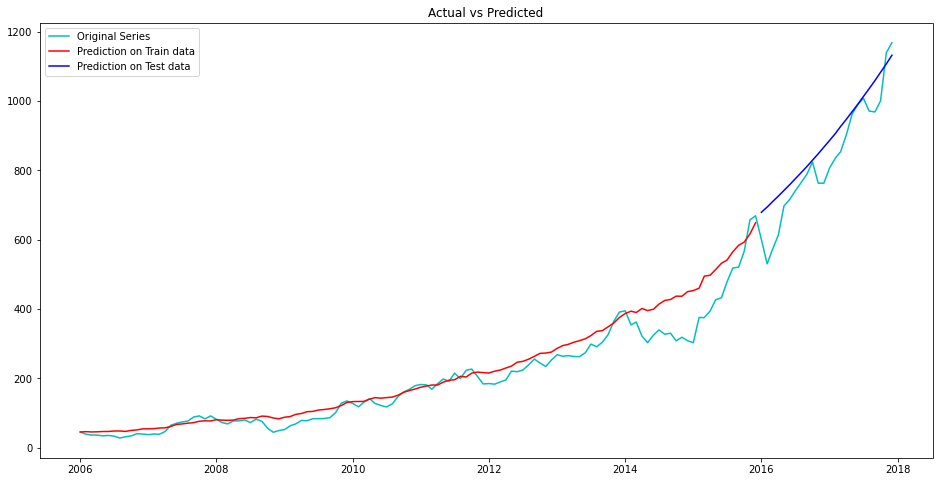

In [34]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df, color = 'c', label = 'Original Series')
plt.plot(predictions_ARIMA, color = 'r', label = 'Prediction on Train data') #plot the predictions_ARIMA series
plt.plot(forecasted_ARIMA, label = 'Prediction on Test data', color='b')  #plot the forecasted_ARIMA series
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- **As observed earlier, most of the predicted values on the training data are very close to the actual values** except for the dip in stock prices in the year 2015.
- **On the test data, the model is able to correctly predict the trend of the stock prices**, as we can see that the blue line appears to be close to the actual values (cyan blue) and they both have an upward trend. **However the test predictions are not able to identify the volatile variations in the stock prices over the last 2 years.**

Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not.

### **Question 9: Check the RMSE on the original train and test data and write your conclusion from the above analysis. (4 Marks)**

In [35]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(predictions_ARIMA, df_train, squared=False) #calculate RMSE using the predictions_ARIMA and df_train 
error

43.27240693475383

In [36]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(forecasted_ARIMA, df_test, squared = False)  #calculate RMSE using the forecasted_ARIMA and df_test
error

73.39354648735788

### Conclusion

- We saw there is an upward trend in the series.
- We confirmed original series is not stationary.
- We made the series moreconstant by using log and differniating the lags
- we made the series stationary by using the ADfullertest  
- The AR model has the lowest MRSE score (0.0900) and AIC value
- Aligned to our observation above, the RMSE is lower on the training data in comparison to the testing data. This implies that the predictions on the training data are closer to the actual values as compared to the testing data.
- Both test and train models are able to correctly predict the trend of the stock prices, however the test predictions are not able to identify the volatility in the stock prices over the last 2 years.
- We can make a more complex time series to get a more generalized model and capture the fluctuations. We can use SARIMA, SARIMAX, etc. while considering more factors like trend, seasonality, etc For example, we can factor in revenue from different Amazon services provided such as AWS, Prime Video, Mobile Apps, Gaming, apps, etc.


### Conclusion Continued

*I made a new dataframe to predict stock price of Amazon as per todays date. Then I will google the current stock price of google and compare to see how well our model is*


In [37]:
forecasted_ARIMA = results_ARIMA.forecast(steps=71) #forecast using the results_ARIMA for next 71 months. Keep steps=71
forecasted_ARIMA[0]

array([6.52115938, 6.54310818, 6.5653318 , 6.58756626, 6.60980115,
       6.63203606, 6.65427097, 6.67650588, 6.69874079, 6.7209757 ,
       6.74321061, 6.76544552, 6.78768043, 6.80991534, 6.83215025,
       6.85438516, 6.87662007, 6.89885498, 6.92108989, 6.9433248 ,
       6.96555971, 6.98779463, 7.01002954, 7.03226445, 7.05449936,
       7.07673427, 7.09896918, 7.12120409, 7.143439  , 7.16567391,
       7.18790882, 7.21014373, 7.23237864, 7.25461355, 7.27684846,
       7.29908337, 7.32131828, 7.34355319, 7.3657881 , 7.38802301,
       7.41025792, 7.43249283, 7.45472774, 7.47696265, 7.49919756,
       7.52143247, 7.54366738, 7.56590229, 7.5881372 , 7.61037211,
       7.63260702, 7.65484193, 7.67707684, 7.69931175, 7.72154666,
       7.74378157, 7.76601648, 7.78825139, 7.8104863 , 7.83272121,
       7.85495612, 7.87719103, 7.89942594, 7.92166085, 7.94389576,
       7.96613067, 7.98836558, 8.01060049, 8.0328354 , 8.05507031,
       8.07730522])

In [38]:
#Making a new series to get the additional dates from 2016-2021

list2 = forecasted_ARIMA[0].tolist()
series2 = pd.Series(list2)
series2

0     6.521159
1     6.543108
2     6.565332
3     6.587566
4     6.609801
        ...   
66    7.988366
67    8.010600
68    8.032835
69    8.055070
70    8.077305
Length: 71, dtype: float64

In [39]:
index = pd.date_range('2016-01-1','2021-12-1' , freq='1M')- pd.offsets.MonthBegin(1)
df2 = pd.DataFrame()
df2['forecasted'] = series2
df2.index = index
df2

,forecasted
2016-01-01,6.521159
2016-02-01,6.543108
2016-03-01,6.565332
2016-04-01,6.587566
2016-05-01,6.609801
...,...
2021-07-01,7.988366
2021-08-01,8.010600
2021-09-01,8.032835
2021-10-01,8.055070


In [40]:
forecasted_ARIMA = np.exp(df2['forecasted']) #use exponential function on forecasted data
forecasted_ARIMA

2016-01-01     679.365574
2016-02-01     694.441677
2016-03-01     710.047448
2016-04-01     726.011794
2016-05-01     742.335393
                 ...     
2021-07-01    2946.477251
2021-08-01    3012.725692
2021-09-01    3080.463661
2021-10-01    3149.724646
2021-11-01    3220.542891
Name: forecasted, Length: 71, dtype: float64

### So stock price of Amazon should be roughly around $3221

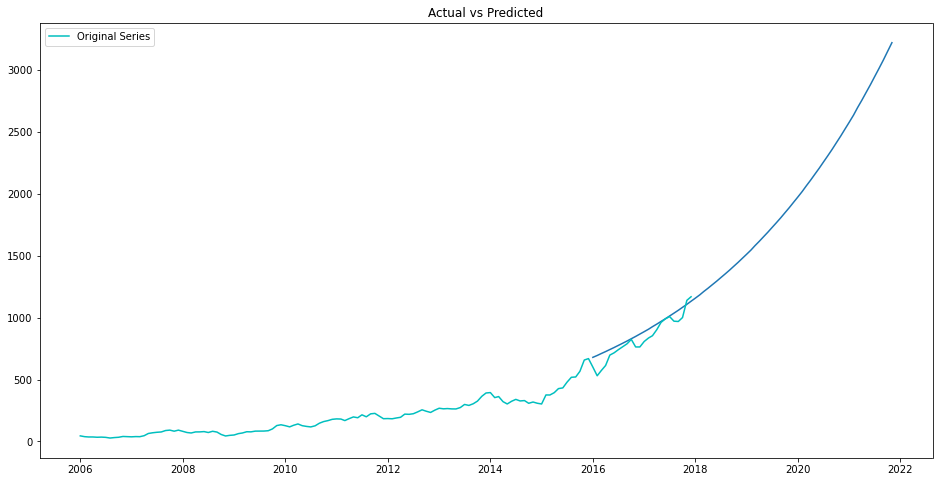

In [41]:
plt.figure(figsize=(16,8))
plt.plot(forecasted_ARIMA)
plt.plot(df, color = 'c', label = 'Original Series')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

### lets google and find current amazon stock price and see if it matches our prediction to judge how good the model is

In [42]:
from PIL import Image
myImage = Image.open("Screenshot 2021-12-07 163639.png");
myImage.show()


<class 'numpy.ndarray'>
(551, 773, 4)


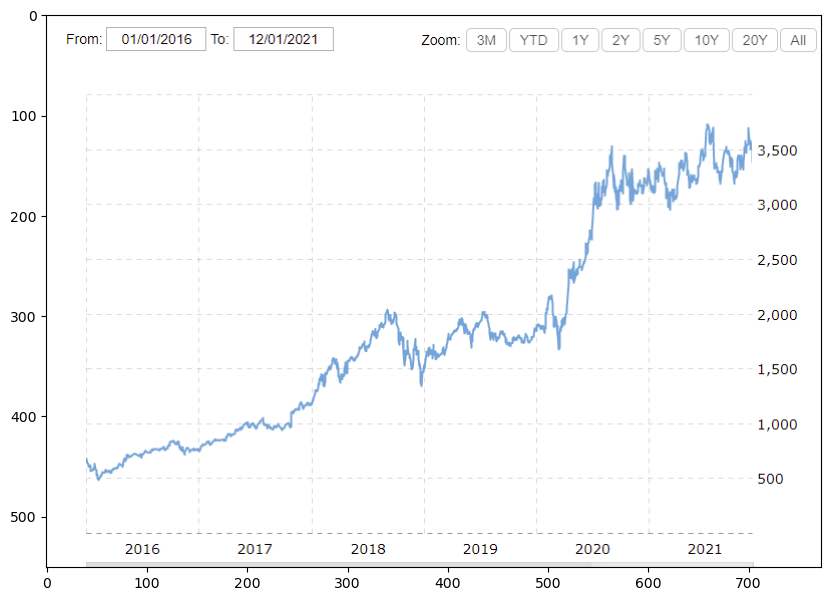

In [43]:
from matplotlib import image
from matplotlib.pyplot import figure

img = image.imread("Screenshot 2021-12-07 163639.png")
figure(figsize=(10, 10), dpi=100)
print(type(img))
print(img.shape)
plt.imshow(img)
plt.show()


<class 'numpy.ndarray'>
(151, 660, 4)


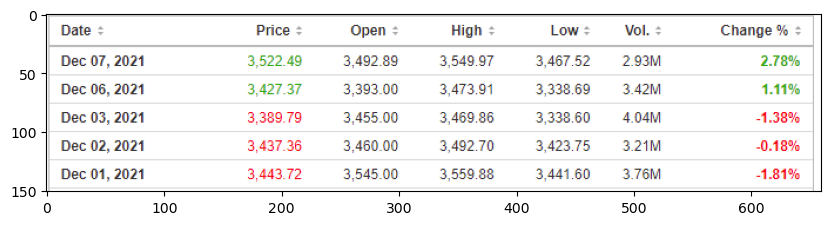

In [44]:
from matplotlib import image
from matplotlib.pyplot import figure

img = image.imread("Screenshot 2021-12-07 165531.png")
figure(figsize=(10, 10), dpi=100)
print(type(img))
print(img.shape)
plt.imshow(img)
plt.show()

### Conclusion Cont

Our model predicted an Amazon stock price for 2021-11-01 at ~ $3220.5

In reality the stock price on 2021-11-01 was $3443.72. From the chart we can see it is following the upward trend well but does not tak einto account volitility at all. We can tune our parameters more!

References/Sources
https://www.macrotrends.net/stocks/charts/AMZN/amazon/stock-price-history